In [2]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()
proxy.__dict__

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (NVIDIA GeForce RTX 3080)


{'input_features_dir': 'simulations2D/input_features',
 'output_targets_dir': 'simulations2D/output_targets',
 'x_data_labels': ['Poro', 'LogPerm', 'Facies', 'Wells'],
 'y_data_labels': ['Pressure', 'Saturation'],
 'return_data': False,
 'n_realizations': 1000,
 'x_channels': 4,
 'y_channels': 2,
 'timesteps': 60,
 'dim': 64,
 'test_size': 0.25,
 't_samples': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60],
 'optimizer': <tensorflow_addons.optimizers.weight_decay_optimizers.AdamW at 0x20656355960>,
 'criterion': <bound method SpatiotemporalCO2.custom_loss of <utils.SpatiotemporalCO2 object at 0x000002067CBD7190>>,
 'L1L2_split': 0.25,
 'loss_alpha': 0.75,
 'regular': <keras.regularizers.L1 at 0x206563552d0>,
 'leaky_slope': 0.25,
 'num_epochs': 100,
 'batch_size': 30,
 'lr_decay': 15,
 'verbose': 0}

In [3]:
proxy.load_data()
proxy.process_data(subsample=None)

X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
MinMax Normalization Done!
Train - X: (750, 64, 64, 4) | y: (750, 11, 64, 64, 2)
Test  - X: (250, 64, 64, 4) | y: (250, 11, 64, 64, 2)


In [4]:
proxy.make_model()

# Parameters: 6,460,518 | Batch size: 30 
Epoch: [10/100] - Loss: 0.1298 - Val Loss: 0.1539
Epoch: [20/100] - Loss: 0.0437 - Val Loss: 0.0853
Epoch: [30/100] - Loss: 0.0329 - Val Loss: 0.0570
Epoch: [40/100] - Loss: 0.0285 - Val Loss: 0.0512
Epoch: [50/100] - Loss: 0.0247 - Val Loss: 0.0473
Epoch: [60/100] - Loss: 0.0225 - Val Loss: 0.0464
Epoch: [70/100] - Loss: 0.0207 - Val Loss: 0.0461
Epoch: [80/100] - Loss: 0.0190 - Val Loss: 0.0443
Epoch: [90/100] - Loss: 0.0180 - Val Loss: 0.0451
Epoch: [100/100] - Loss: 0.0167 - Val Loss: 0.0426
Training Time: 10.89 minutes


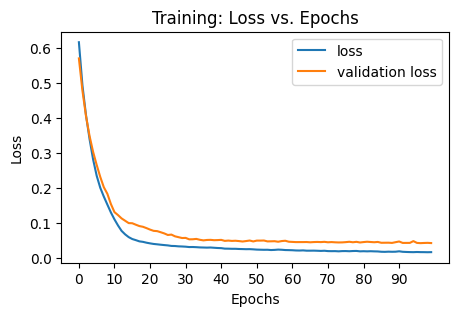

In [5]:
proxy.training()

In [6]:
proxy.predictions()

8/8 [==============================] - 1s 73ms/step
Train pred: (750, 11, 64, 64, 2) | Test pred: (250, 11, 64, 64, 2)
MSE  | Train: 1.77e-03, Test: 4.39e-03
SSIM | Train: 93.15, Test: 86.77


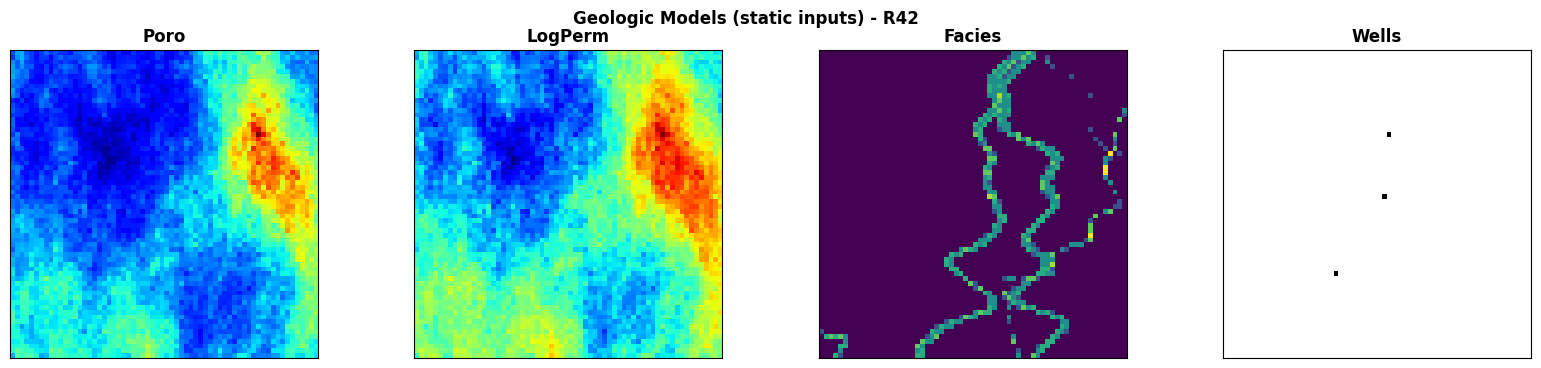

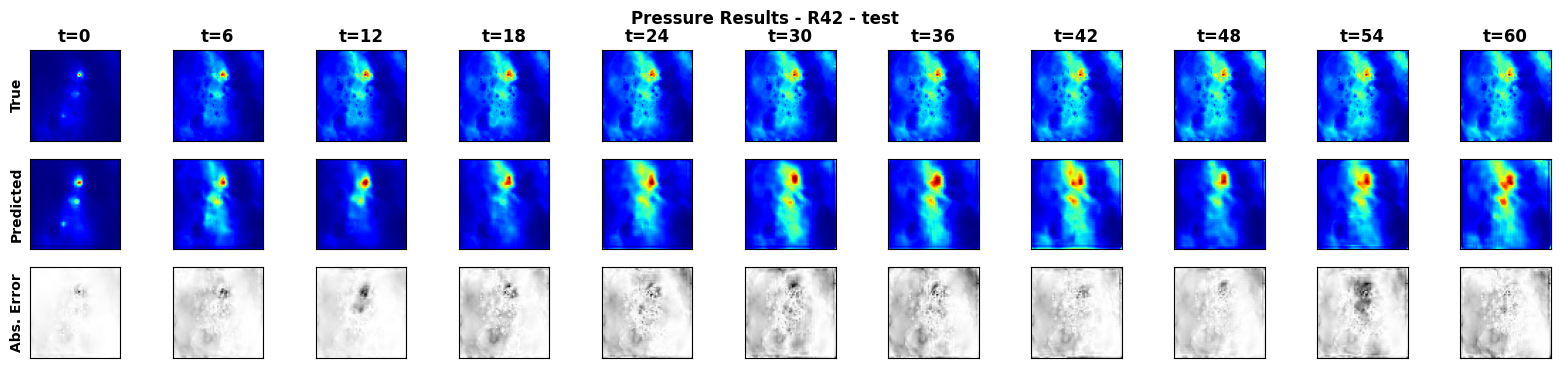

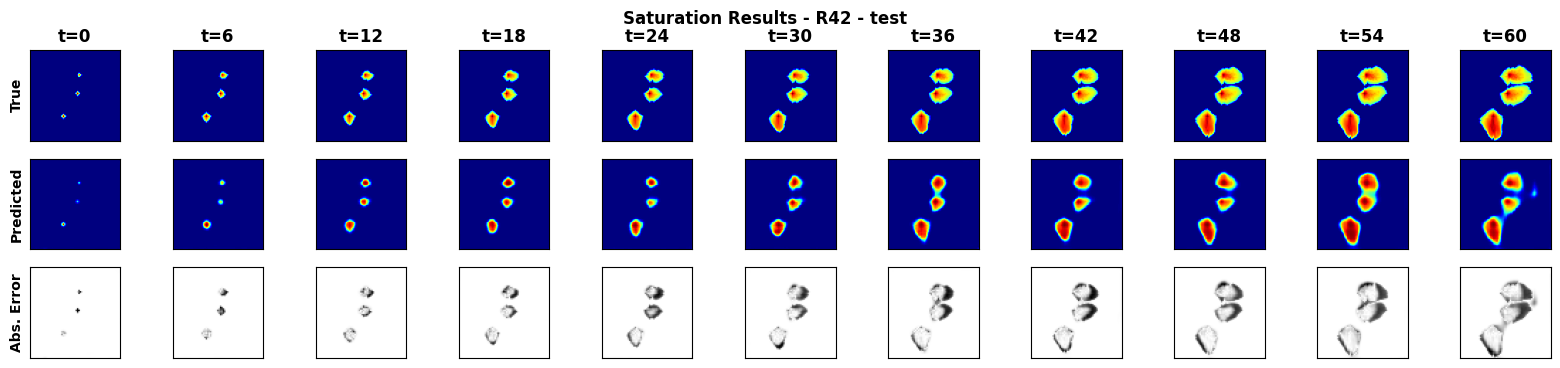

In [127]:
proxy.plot_single_results(42, 'test', cmaps=['jet','jet','viridis','binary','binary'])

Train - Mean CO2 Injected: True: 5266.64 | Pred: 4938.95
Test  - Mean CO2 Injected: True: 5494.65 | Pred: 4868.34


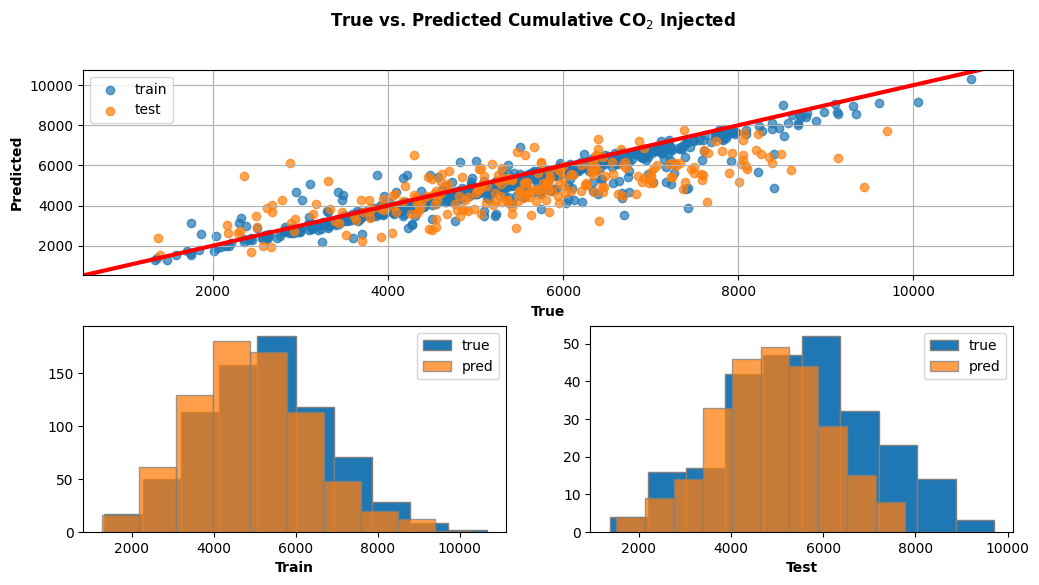

In [8]:
proxy.cumulative_co2()

***
# END